# Bank Loan Application Modelling
## Context

#### Before approving a loan, the company calculates the probability that the borrower will default.
#### It is therefore looking for a scoring algorithm that will enable it to decide whether or not to lend to a given borrower.

In [2]:
%config IPCompleter.greedy=True
import pandas as pd
import numpy as nm
import matplotlib.pyplot as plt
import warnings
import random
warnings.filterwarnings("ignore")

In [3]:
def chooseColor():
    colors=['b', 'g', 'r','c','m','y']
    return colors[random.randint(0,5)]

In [4]:
def NanTooMany(dataq):
    mis_val_percent = pd.DataFrame(100 * dataq.isnull().sum() / len(dataq))
    mis_val_percent= mis_val_percent[mis_val_percent[0]>=50]
    print("Missing values in percentage, columns to drop")
    print(mis_val_percent.sort_values(by=0,ascending=False))
    mis_val_percent.index.name="name"
    for index in mis_val_percent.iterrows(): 
        dataq=dataq.drop(index[0],axis=1)
    return dataq

In [5]:
def checkMatches(data,dat):
    sat=set(data['SK_ID_CURR']) & set(dat['SK_ID_CURR'])
    match=len(sat)/len(data['SK_ID_CURR'])
    print("percent of matching records: "+ str(match))
    if match>0.70:
        dataq=pd.merge(data, dat, how='left', on='SK_ID_CURR')
    return dataq

# Data Selection
## Three datafiles are selected to meet the project needs
- application_train includes data for current credit application and binary TARGET variable 
- bureau includes data on previous credits issued for a specific application available in application_train
- previous_application includes data on previous applications submited to the same institution

### Keeping columns that include less than 50% of missing values
_output provides list of the droped columns and missing values percent per data file_

In [61]:
application = pd.read_csv("application_test.csv")
bureau = pd.read_csv("bureau.csv")
previous_app = pd.read_csv("previous_application.csv")
application=NanTooMany(application)
bureau=NanTooMany(bureau)
previous_app=NanTooMany(previous_app)

Missing values in percentage, columns to drop
                              0
COMMONAREA_MODE          68.716
COMMONAREA_AVG           68.716
COMMONAREA_MEDI          68.716
NONLIVINGAPARTMENTS_MEDI 68.413
NONLIVINGAPARTMENTS_AVG  68.413
NONLIVINGAPARTMENTS_MODE 68.413
FONDKAPREMONT_MODE       67.284
LIVINGAPARTMENTS_MEDI    67.249
LIVINGAPARTMENTS_AVG     67.249
LIVINGAPARTMENTS_MODE    67.249
FLOORSMIN_MEDI           66.605
FLOORSMIN_MODE           66.605
FLOORSMIN_AVG            66.605
OWN_CAR_AGE              66.289
YEARS_BUILD_AVG          65.276
YEARS_BUILD_MODE         65.276
YEARS_BUILD_MEDI         65.276
LANDAREA_AVG             57.964
LANDAREA_MODE            57.964
LANDAREA_MEDI            57.964
BASEMENTAREA_MODE        56.706
BASEMENTAREA_MEDI        56.706
BASEMENTAREA_AVG         56.706
NONLIVINGAREA_AVG        53.512
NONLIVINGAREA_MODE       53.512
NONLIVINGAREA_MEDI       53.512
ELEVATORS_MODE           51.676
ELEVATORS_MEDI           51.676
ELEVATORS_AVG            5

## Target Variable Distribution

### Supervised learning is based on labeled data
### The dataset inludes target variable

* 1 Defaulted applications
* 0 Repaid applications

_data set is unbalanced which is important for model accuracy method selection_

In [7]:

d= application['TARGET'].value_counts()
plt.figure(figsize=(10,1))
plt.title("TARGET")
y_pos = nm.arange(len(d.index))
        # Create horizontal bars
plt.barh( d.index, d.values,color= chooseColor())
 
        # Create names on the y-axis
plt.yticks(y_pos, ['Repaid','Defaulted'])
plt.show()

KeyError: 'TARGET'

<h1><u>Feature engineering</u></h1>

The dataset includes raw data. The following part includes engineering of various features that could help us to explain why certain customers are defaulted in reapying their credits. 

For every new fetuare we control the percentage of corresponding records if coming from different datatables

### 1. Binary Overdue
#### if current applicant has a credit overdue on any other credit registered at the authorities ( 1 if overdue, 0 his credit histrory has no negative records)

In [62]:
##adding overdue column 1 if overdue for a app exists
bureau_overdue= bureau[['SK_ID_CURR','AMT_CREDIT_SUM_OVERDUE']]
bureau_overdue= bureau_overdue.groupby(by='SK_ID_CURR').max().reset_index()
bureau_overdue['overdue']=bureau_overdue['AMT_CREDIT_SUM_OVERDUE'].apply(lambda x: 1 if x >0 else 0)
bureau_overdue=bureau_overdue.drop('AMT_CREDIT_SUM_OVERDUE', axis=1)
application1= checkMatches(application,bureau_overdue)
d=application1['overdue'].value_counts()
d

percent of matching records: 0.8682094206466436


0.000    41853
1.000      467
Name: overdue, dtype: int64

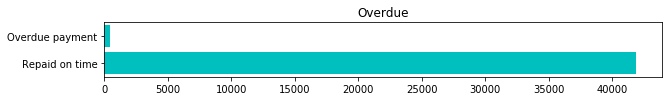

In [63]:
plt.figure(figsize=(10,1))
plt.barh(d.index,d.values,color= chooseColor())
plt.title("Overdue")
y_pos = nm.arange(len(d.index))
plt.yticks(y_pos, ['Repaid on time','Overdue payment'])
plt.show()

### 2. Binary New Customer
#### We like to investigate if the current aplicant has already applied to credit at this institution ( 1 if new customer otherwise 0)

In [64]:
##adding new customer column 1 if new customer
has_previous_application=set(previous_app['SK_ID_CURR']) & set(application['SK_ID_CURR'])
dt={'SK_ID_CURR':list(has_previous_application)}
newCustomers=pd.DataFrame(dt)
newCustomers['new_customer']=0
application1=checkMatches(application1,newCustomers)
application1['new_customer']=application1['new_customer'].apply(lambda x: 1 if x!=0 else 0)
d=application1['new_customer'].value_counts()
d


percent of matching records: 0.9806335138683735


0    47800
1      944
Name: new_customer, dtype: int64

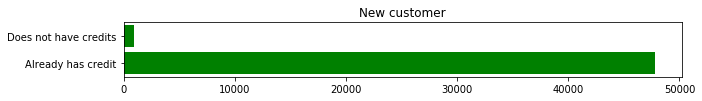

In [65]:
plt.figure(figsize=(10,1))

plt.barh(d.index,d.values,color= chooseColor())
plt.title("New customer")
y_pos = nm.arange(len(d.index))
        # Create names on the y-axis
plt.yticks(y_pos, ['Already has credit','Does not have credits'])
plt.show()

### 3.Binary Last contract status
#### To investigate if the last application/offer was approved , rejected, unused, canceled ( 1 if positive: approved, unused. 0 if negative)

In [66]:
##adding column last contract status 1 is positive ( approved and unused offer) othrwise 0
hello=previous_app[['SK_ID_CURR','SK_ID_PREV', 'NAME_CONTRACT_STATUS']].groupby(by='SK_ID_CURR').max().reset_index()
hello['lastContractStatus']= hello['NAME_CONTRACT_STATUS'].apply(lambda x: 1 if x=='Approved'or x=='Unused offer' else 0)
new_pv_app=hello[['SK_ID_CURR','lastContractStatus']]
application1=checkMatches(application1,new_pv_app)
d=application1['lastContractStatus'].value_counts()
d


percent of matching records: 0.9806335138683735


0.000    26467
1.000    21333
Name: lastContractStatus, dtype: int64

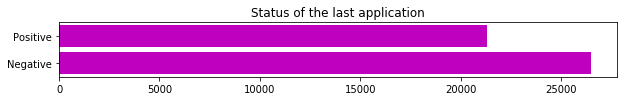

In [67]:
plt.figure(figsize=(10,1))
plt.barh(d.index,d.values,color= chooseColor())
plt.title("Status of the last application")
y_pos = nm.arange(len(d.index))
 
        # Create names on the y-axis
plt.yticks(y_pos, ['Negative','Positive'])
plt.show()

### 4.Converting days from birth to years from birth

Our dataset includes days from birth which is probably should be converted into years to see if there is a relationship between age of a person and payment default

In [68]:
application1['DAYS_BIRTH']= pd.to_numeric(application1['DAYS_BIRTH'].abs()/365, downcast="signed")
application1['YEARS_BIRTH']=application1['DAYS_BIRTH']
application1=application1.drop('DAYS_BIRTH',axis=1)
application1['YEARS_BIRTH'].describe()

count   48744.000
mean       44.022
std        11.852
min        20.104
25%        34.236
50%        43.247
75%        53.800
max        69.027
Name: YEARS_BIRTH, dtype: float64

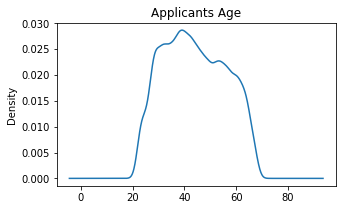

In [69]:
application1['YEARS_BIRTH'].plot(kind='density',figsize=(5,3), title="Applicants Age")

## 5.Converting days since started new job to months

Similary to the above, we like to invesigate the number of months person spent on the last place of work. We choose months over years because we cannot expect from an employee staying significant number of years with the same employee.

In [70]:
application1['DAYS_EMPLOYED']= pd.to_numeric(application1['DAYS_EMPLOYED'].abs(), downcast="signed")
application1['MONTHS_EMPLOYED']=application1['DAYS_EMPLOYED']/30
application1=application1.drop('DAYS_EMPLOYED',axis=1)
med=application1['MONTHS_EMPLOYED'].median()
application1['MONTHS_EMPLOYED']=application1['MONTHS_EMPLOYED'].apply(lambda x :med if x>4800 else x)
application1['MONTHS_EMPLOYED'].describe()

count   48744.000
mean       82.274
std        69.230
min         0.033
25%        34.933
50%        81.067
75%        97.000
max       582.100
Name: MONTHS_EMPLOYED, dtype: float64

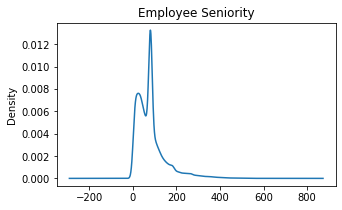

In [71]:
application1['MONTHS_EMPLOYED'].plot(kind='density',figsize=(5,3), title="Employee Seniority")


## 6.Number of documents provided by a customer

Probably number of provided documents has relationship with payment default. Additional documents might have some prove of applicants financial stability.

In [72]:
coro=application1.filter(regex=('FLAG_DOCUMENT_') )
coro['SK_ID_CURR']=application1['SK_ID_CURR']
coro['TARGET']=application1['TARGET']
coro['totalDocuments']=coro[['FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_4',
                    'FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7','FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10',
                    'FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13','FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16',
                    'FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21']].sum(axis=1)
d=coro['totalDocuments'].value_counts()
d

1    47997
0      747
Name: totalDocuments, dtype: int64

#### Investigate if the totalDocuments and Target are independent

We want to investigate if defaults can be explained by low number of provided documents 

_method cross-tabulation, chi square_
Assumptions:
* independence
* cell number should be higher than 5

Null hypotesis:target variable is independent of number of documents provided.

In [44]:
hu=pd.crosstab(coro['TARGET'],coro['totalDocuments'])
hu.head()

totalDocuments,0,1,2,3,4
TARGET,,,,,
0,27917,247239,7383,147,0
1,1632,22817,359,16,1


In [45]:
##checking is there is association : H0=variables are independent
from scipy import stats
chi2, p, dof, ex=stats.chi2_contingency(hu)
print(str(p)+" p < 0.05 reject H0. Variables are not independent and \n there is a relationship between number of provided documents and default")

3.950449223466765e-95 p < 0.05 reject H0. Variables are not independent and 
 there is a relationship between number of provided documents and default


#### Binary if customer provided documents
Derivating fetuare to see if those customers who have provided documents have not defalted

##### 1 at least document was provided

In [73]:
coro['document_provided']=coro['totalDocuments'].apply(lambda x: 1 if x > 0  else 0)
d=coro['document_provided'].value_counts()
d

1    47997
0      747
Name: document_provided, dtype: int64

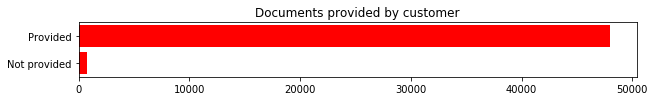

In [74]:
plt.figure(figsize=(10,1))
plt.barh(d.index,d.values,color=chooseColor())
plt.title("Documents provided by customer")
y_pos = nm.arange(len(d.index))

        # Create names on the y-axis
plt.yticks(y_pos, ['Not provided','Provided'])
plt.show()

In [75]:
application1=application1[application1.columns.drop(list(application1.filter(regex='FLAG_DOCUMENT_')))]
application1['document_provided']=coro['document_provided']
application1['totalDocuments']=coro['totalDocuments']


## 7.Sum current credit (quantitative)

Investigate if there is a relationship between sum of current credits and credit default


In [76]:
##current credit volume
bureau['AMT_CREDIT_SUM_DEBT']=bureau['AMT_CREDIT_SUM_DEBT'].fillna(0).abs()
credit=pd.DataFrame({'SK_ID_CURR':bureau['SK_ID_CURR'], 'debt':bureau['AMT_CREDIT_SUM_DEBT']})
credit=credit.groupby(by='SK_ID_CURR').sum().reset_index()
application3=checkMatches(application1,credit)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
application3['debt'].describe()




percent of matching records: 0.8682094206466436


count      42320.000
mean      736497.536
std      1679651.535
min            0.000
25%            0.000
50%       207099.000
75%       789801.131
max     65441403.000
Name: debt, dtype: float64

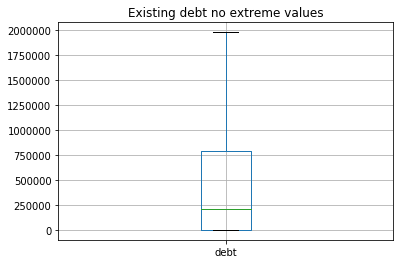

In [77]:
plt.title("Existing debt no extreme values")
application3.boxplot(column='debt',showfliers=False, figsize=(5,5))

## 8.Binary Repaid all credits

Investigate if all previously taken credits have been repaid.

#### 1 if all the taken credit have been repaid

In [78]:
##if al credit talen by customer have been repaid
bureau['CREDIT_SCORE']=bureau['CREDIT_ACTIVE'].apply(lambda x :1 if x=="Closed" else -200)
nn={'SK_ID_CURR':bureau['SK_ID_CURR'],'repaidCredit':bureau['CREDIT_SCORE']}
gooCustomer=pd.DataFrame(nn)
gooCustomer=gooCustomer.groupby(by='SK_ID_CURR').sum().reset_index()
gooCustomer['repaidCredit']=gooCustomer['repaidCredit'].apply(lambda x:1 if x>0 else 0)
application4= checkMatches(application3, gooCustomer)
d= application4['repaidCredit'].value_counts()
d


percent of matching records: 0.8682094206466436


0.000    34743
1.000     7577
Name: repaidCredit, dtype: int64

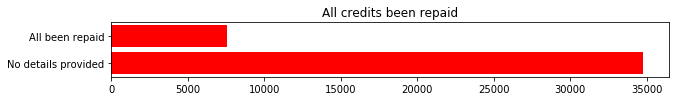

In [79]:
plt.figure(figsize=(10,1))
plt.barh(d.index,d.values,color=chooseColor())
plt.title("All credits been repaid")
y_pos = nm.arange(len(d.index))
 

 
        # Create names on the y-axis
plt.yticks(y_pos, ['No details provided','All been repaid'])
plt.show()

## 9.Binary Repaid Last Credit
 #### 1 if repaid
 
 The number of defaulted customers is low so we will only study not defaulted customers
 
 

In [80]:
##bureau1 = pd.read_csv("bureau.csv")
##if the last credit has been repaid
lastCredit=pd.DataFrame({"dateClosed":bureau['DAYS_CREDIT_ENDDATE'],'SK_ID_CURR':bureau['SK_ID_CURR'],'status':bureau['CREDIT_ACTIVE']})
lastCredit['dateClosed']=lastCredit['dateClosed'].apply(lambda x :x if x<=0 else 1)
lastCredit['status']=lastCredit['status'].apply(lambda x :1 if x=="Closed" else 0)
lastCredit=lastCredit[lastCredit['dateClosed']<=0]
lastCredit=lastCredit.groupby(by='SK_ID_CURR').max().reset_index()
lastCreditPaid=pd.DataFrame(lastCredit[lastCredit['status']==1])
lastCreditFail=pd.DataFrame(lastCredit[lastCredit['status']==0])
print("repaid customers: "+str(len(lastCreditPaid))+ " defauled customers: "+ str(len(lastCreditFail)))
lastCreditPaid.drop('status',axis=1)
lastCreditFail.drop('status',axis=1)
application5= checkMatches(application4,lastCreditPaid)
application5['repaidLastCredit']= application5['dateClosed'].apply(lambda x:1 if x<=0 else 0)
application5=application5.drop('dateClosed',axis=1)
application5=application5.drop('status', axis=1)
d= application5['repaidLastCredit'].value_counts()
d


repaid customers: 256424 defauled customers: 7055
percent of matching records: 0.7432504513376005


1    36229
0    12515
Name: repaidLastCredit, dtype: int64

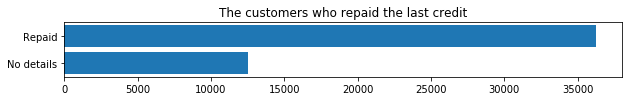

In [81]:
plt.figure(figsize=(10,1))
plt.barh(d.index,d.values,color=chooseColor())
plt.title("The customers who repaid the last credit")
y_pos = nm.arange(len(d.index))
 
        # Create horizontal bars
plt.barh( d.index, d.values)
 
        # Create names on the y-axis
plt.yticks(y_pos, ['No details','Repaid'])
plt.show()

<h1> <u>AVAILABLE VARIABLES AFTER FEATURE ENGINEERING</u></h1>

In [82]:
application5.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'APARTMENTS_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'ENTRANCES_AVG',
   

<h1><u> QUANTITATIVE DATA REVIEW </u></h1>

Start with studing correlation between target and available variables we will follow to review the relationship on the pairplot. 


In [ ]:
quant= application5[['TARGET','CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',  'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',  'CNT_FAM_MEMBERS', 
          'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2','REGION_POPULATION_RELATIVE', 'EXT_SOURCE_3','YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG',
        'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MEDI', 'TOTALAREA_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 
        'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
'YEARS_BIRTH', 'MONTHS_EMPLOYED',  'totalDocuments', 'debt']]


## Correlation with target variable

Using Spearman correlation to investigate if there is any relationship between target variable and other quantitative fetuares

Spearman correlation assumptions:
- same level of measurement
- related pairs
- absence of outliers
- normality of variables
- linearity
- homoscedasticity

In [ ]:
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()
scaler.fit(quant)
qnt=pd.DataFrame(scaler.transform(quant), columns= quant.columns)
quant.corr('spearman')['TARGET'].sort_values(ascending=False)

The correlation resultis are rather poor so to continue with our analysis we wlll keep only features with at least 4% correlation.
Data visualisation will help us to see if data distribution, linearity, absence of outliers. The purpose of the data visualisation analysis is to investigate what variables should be chosen for model built with help of logistic regression and how they need to be preprocessed.

## Data Visulaization and Outliers Identification

In [ ]:
import seaborn as s
visual=quant[['TARGET','AMT_INCOME_TOTAL','DAYS_LAST_PHONE_CHANGE','DAYS_ID_PUBLISH','debt',
'DAYS_REGISTRATION','DEF_30_CNT_SOCIAL_CIRCLE','FLOORSMAX_AVG','MONTHS_EMPLOYED','YEARS_BIRTH','EXT_SOURCE_2','EXT_SOURCE_3']]
s.pairplot(visual)

We can identify outliers in debt, default 30 days count in the social circle as well as the income columns.
the distribution of variables is not normal.


<h1><u> Preparing and cleaning the data </u></h1>

## Processing missing values

The dataset still includes some missing values
The following is the methods to replace them:

- quantitative variable replaced with the variable median
- categorical variables replaced with the variable frequency
- binary depending on case: 0 or add 3 option

Extreme values are removed(1% of top observations )
Y,N columns are refactored to 1,0
Data is normalized to fit with previously normilized data


## Spliting labeled data into test and train. ratio 0,3/0,7
Further analysis require data splitting into test and train data.
* Train data in to be used for mode training
* Test data is used to evaluate the model

Training data shape and available columns:

In [83]:
def flagReplace(list,data):
    for i in list:
        data[i]=data[i].apply(lambda x:1 if x=="Y" else 0)
    return data

In [84]:
def removeOutliers(array,data):
    for i in array:
        quant=data[i].quantile(0.99)
        med=data[i].median()
        ##data[i]=data[i][data[i]<quant]
        data[i]=data[i].apply(lambda x:med if x >quant else x)
    return data

In [85]:
def replaceColumn(list,train1, train):
    for i in list:
        train[i]=train1[i]
    return train

def fillNaNumber(list,train, number):
    for i in list:
        if number=="median":
            train[i]=train[i].fillna(train[i].median())
           
        elif number== "freq":
            train[i] = train[i].fillna(train[i].value_counts().index[0])
        else:
            train[i]=train[i].fillna(number)
    return train

In [87]:
prp= application5[['SK_ID_CURR','TARGET','EXT_SOURCE_2','EXT_SOURCE_3','debt','CNT_CHILDREN','new_customer','totalDocuments','overdue','lastContractStatus','document_provided','repaidCredit','repaidLastCredit','AMT_INCOME_TOTAL','DAYS_LAST_PHONE_CHANGE','DAYS_ID_PUBLISH','DAYS_REGISTRATION',
                    'DEF_30_CNT_SOCIAL_CIRCLE','FLOORSMAX_AVG','MONTHS_EMPLOYED','YEARS_BIRTH','CNT_FAM_MEMBERS', 'CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY']]
prp=fillNaNumber(['EXT_SOURCE_2','EXT_SOURCE_3','debt','CNT_CHILDREN','new_customer','totalDocuments','document_provided','repaidLastCredit'],prp,0)
prp=fillNaNumber(['repaidCredit','overdue','lastContractStatus'],prp,2)
prp=fillNaNumber(['AMT_INCOME_TOTAL','DAYS_LAST_PHONE_CHANGE','DAYS_ID_PUBLISH','DAYS_REGISTRATION',
                    'DEF_30_CNT_SOCIAL_CIRCLE','FLOORSMAX_AVG','MONTHS_EMPLOYED','YEARS_BIRTH','CNT_CHILDREN'],prp,"median")
prp=fillNaNumber(['CNT_FAM_MEMBERS', 'CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY'],prp,"freq")
prp=flagReplace(['FLAG_OWN_CAR','FLAG_OWN_REALTY'],prp)
prp['CODE_GENDER']=prp['CODE_GENDER'].apply(lambda x :1 if x=="M" else 2)
prp=removeOutliers(['AMT_INCOME_TOTAL','debt','DEF_30_CNT_SOCIAL_CIRCLE'],prp)

from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()
arr=['debt','AMT_INCOME_TOTAL','DAYS_LAST_PHONE_CHANGE','DAYS_ID_PUBLISH','DAYS_REGISTRATION','DEF_30_CNT_SOCIAL_CIRCLE','FLOORSMAX_AVG','MONTHS_EMPLOYED','YEARS_BIRTH']
norm = pd.DataFrame(prp[arr], columns=arr)
scaler.fit(norm)
trainN=pd.DataFrame(scaler.transform(norm), columns=arr)

t=replaceColumn(arr,trainN,prp)
final= t


In [ ]:
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
train, test = train_test_split(final, test_size=0.3, random_state=1)
train.shape

In [ ]:
train.columns

Our dataset is inbalanced so accuracy is not good measure here, it only takes into account only number of correct assesments( TP and TN). 

For the further analysis AUC is better measure it takes both TP and FP

## Logistic regression: selecting model parameters 
_using rsquare to identify most beneficial linear and polynomial models_

Looping thought all available combinations of variables we add new variable to our formula is Rsquared is increased and pvalues of the cooficientis not higher than 0,05

We conduct optimal model parameter search for linear model first after for polynomial squared component degree.In the latter case we compare if adding polynomial component is more beneficial than adding linear.




In [ ]:
def findlinear(prepare,train):
    results={}
    formul="TARGET~"
    for cl in prepare:
        formul1=formul
        formul+=cl
        res = smf.logit(formul, data = train).fit()
        check=False
        for p in res.pvalues.values:
            if p>=0.05:
                check=True
                formul=formul1
        if check == False:
            results[formul]=res.prsquared
            formul+="+"
    return pd.Series(results)

def findPolyn(prepare, power,train):
    results={}
    formul="TARGET~"
    for cl in prepare:
        formul1=formul
        if cl[0:2]!="C(":
            formulL=formul+cl
            formulP=formul+"nm.power( "+cl+" ,"+str(power)+" )"
            resL = smf.logit(formulL, data = train).fit()
            resP= smf.logit(formulP, data = train).fit()
            checkL=False
            checkP=False
            for p in resL.pvalues.values:
                if p>=0.05:
                    checkL=True
                
            for p in resP.pvalues.values:
                if p>=0.05:
                    checkP=True
            final=""
            if  checkL==True and checkP==False:
                formul= formulP
                results[formul]=resP.prsquared
                formul+="+"
            elif checkP==True and checkL==False:
                formul= formulL
                results[formul]=resL.prsquared
                formul+="+"
            elif  checkL==False and checkP==False and resL.prsquared > resP.prsquared:
                formul= formulL
                results[formul]=resL.prsquared
                formul+="+"
            elif  checkL==False and checkP==False and resL.prsquared < resP.prsquared:
                formul= formulP
                results[formul]=resP.prsquared
                formul+="+"
            elif checkL==True and checkP==True:
                formul=formul1
        else:
            formul+=cl
            
            res = smf.logit(formul, data = train).fit()
            check=False
            for p in res.pvalues.values:
                if p>=0.05:
                    check=True
                    formul=formul1
            if check == False:
                results[formul]=res.prsquared
                formul+="+"
        
    return pd.Series(results)

#### Formulae for linear  and baseline model

payment default is dependent on the following factors:

RSquared score is 0.079

TARGET~EXT_SOURCE_2+EXT_SOURCE_3+debt+CNT_CHILDREN+totalDocuments+DAYS_LAST_PHONE_CHANGE+DAYS_ID_PUBLISH+DAYS_REGISTRATION+DEF_30_CNT_SOCIAL_CIRCLE+FLOORSMAX_AVG+MONTHS_EMPLOYED+CNT_FAM_MEMBERS+C(new_customer)+C(FLAG_OWN_CAR)+C(overdue)+C(document_provided)+C(repaidLastCredit)


In [ ]:
'''
prepare= ['EXT_SOURCE_2', 'EXT_SOURCE_3','totalDocuments','DAYS_LAST_PHONE_CHANGE','debt','FLOORSMAX_AVG', 'MONTHS_EMPLOYED', 'YEARS_BIRTH', 'CNT_FAM_MEMBERS',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'DEF_30_CNT_SOCIAL_CIRCLE',
          'C(FLAG_OWN_CAR)', 'C(FLAG_OWN_REALTY)','C(new_customer)', 'C(overdue)',
         'C(repaidCredit)','C(repaidLastCredit)']

'''
prepare= ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'debt',
       'CNT_CHILDREN', 'totalDocuments',
        'AMT_INCOME_TOTAL', 'DAYS_LAST_PHONE_CHANGE',
       'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'FLOORSMAX_AVG', 'MONTHS_EMPLOYED', 'YEARS_BIRTH', 'CNT_FAM_MEMBERS','C(new_customer)',
       'C(FLAG_OWN_CAR)', 'C(FLAG_OWN_REALTY)', 'C(overdue)',
        'C(document_provided)', 'C(repaidCredit)','C(repaidLastCredit)','C(lastContractStatus)']
linear=findlinear(prepare,train)
print(linear.sort_values(ascending=False).head(3))


### Formulas for polymonial model

Rsquare measure for the best model: 0.81

EXT_SOURCE_2+ EXT_SOURCE_3^2+debt+CNT_CHILDREN+totalDocuments+AMT_INCOME_TOTAL^2+DAYS_LAST_PHONE_CHANGE^2+DAYS_ID_PUBLISH^2 + DAYS_REGISTRATION^2+DEF_30_CNT_SOCIAL_CIRCLE+MONTHS_EMPLOYED+CNT_FAM_MEMBERS^2+overdue+document_provided+repaidLastCredit+lastContractStatus

a less performant polynomial models:

EXT_SOURCE_2+ EXT_SOURCE_3^2+debt+CNT_CHILDREN+totalDocuments+AMT_INCOME_TOTAL^2+DAYS_LAST_PHONE_CHANGE^2+DAYS_ID_PUBLISH^2 + DAYS_REGISTRATION^2+DEF_30_CNT_SOCIAL_CIRCLE+MONTHS_EMPLOYED+CNT_FAM_MEMBERS^2+overdue+document_provided+repaidLastCredit

EXT_SOURCE_2+ EXT_SOURCE_3^2+debt+CNT_CHILDREN+totalDocuments+AMT_INCOME_TOTAL^2+DAYS_LAST_PHONE_CHANGE^2+DAYS_ID_PUBLISH^2 + DAYS_REGISTRATION^2+DEF_30_CNT_SOCIAL_CIRCLE+MONTHS_EMPLOYED+CNT_FAM_MEMBERS^2+overdue+document_provided

In [ ]:
polynomial=findPolyn(prepare,2,train)
print(polynomial.sort_values(ascending=False).head(3))

### Compare models based on 6 selected formulas


3 best performant linear models and 3 best performant polynomial

Assessing with McFadden's pseudo R2 and RMSE

R-squared is used to calculate the goodness of fit of a model. Regression R-squared has higher values between 0 and 1 for pseudo R squred the values are somehow smaller. Good fit according to McFadden is around 0.2 -0.4
R squared is Explained variation / Total variation
Pseudo R squared is the ratio of explained log likelihood and  intercept log likelihood

Root Mean Square Error is the measure that shows deviation of residuals from the model

We like to maximze Pseudo Rsquared but minimize RMSE

In [ ]:

formulas=['TARGET~EXT_SOURCE_2+EXT_SOURCE_3+debt+CNT_CHILDREN+totalDocuments+DAYS_LAST_PHONE_CHANGE+DAYS_ID_PUBLISH+DAYS_REGISTRATION+DEF_30_CNT_SOCIAL_CIRCLE+FLOORSMAX_AVG+MONTHS_EMPLOYED+CNT_FAM_MEMBERS+C(new_customer)+C(FLAG_OWN_CAR)+C(overdue)+C(document_provided)+C(repaidLastCredit)',
'TARGET~EXT_SOURCE_2+EXT_SOURCE_3+debt+CNT_CHILDREN+totalDocuments+DAYS_LAST_PHONE_CHANGE+DAYS_ID_PUBLISH+DAYS_REGISTRATION+DEF_30_CNT_SOCIAL_CIRCLE+FLOORSMAX_AVG+MONTHS_EMPLOYED+CNT_FAM_MEMBERS+C(new_customer)+C(FLAG_OWN_CAR)+C(overdue)+C(document_provided)',
'TARGET~EXT_SOURCE_2+EXT_SOURCE_3+debt+CNT_CHILDREN+totalDocuments+DAYS_LAST_PHONE_CHANGE+DAYS_ID_PUBLISH+DAYS_REGISTRATION+DEF_30_CNT_SOCIAL_CIRCLE+FLOORSMAX_AVG+MONTHS_EMPLOYED+CNT_FAM_MEMBERS+C(new_customer)+C(FLAG_OWN_CAR)+C(overdue) ']
    
sqrtFormulas=['TARGET~EXT_SOURCE_2+nm.power( EXT_SOURCE_3 ,2 )+debt+CNT_CHILDREN+totalDocuments+nm.power( AMT_INCOME_TOTAL ,2 )+DAYS_LAST_PHONE_CHANGE+DAYS_ID_PUBLISH+DAYS_REGISTRATION+DEF_30_CNT_SOCIAL_CIRCLE+FLOORSMAX_AVG+MONTHS_EMPLOYED+CNT_FAM_MEMBERS+C(new_customer)+C(overdue)+C(document_provided)+C(repaidCredit)+C(repaidLastCredit)',
'TARGET~EXT_SOURCE_2+nm.power( EXT_SOURCE_3 ,2 )+debt+CNT_CHILDREN+totalDocuments+nm.power( AMT_INCOME_TOTAL ,2 )+DAYS_LAST_PHONE_CHANGE+DAYS_ID_PUBLISH+DAYS_REGISTRATION+DEF_30_CNT_SOCIAL_CIRCLE+FLOORSMAX_AVG+MONTHS_EMPLOYED+CNT_FAM_MEMBERS+C(new_customer)+C(overdue)+C(document_provided)+C(repaidCredit)',
'TARGET~EXT_SOURCE_2+nm.power( EXT_SOURCE_3 ,2 )+debt+CNT_CHILDREN+totalDocuments+nm.power( AMT_INCOME_TOTAL ,2 )+DAYS_LAST_PHONE_CHANGE+DAYS_ID_PUBLISH+DAYS_REGISTRATION+DEF_30_CNT_SOCIAL_CIRCLE+FLOORSMAX_AVG+MONTHS_EMPLOYED+CNT_FAM_MEMBERS+C(new_customer)+C(overdue)+C(document_provided)']
def compareMods(formulas,train):
    for f in formulas:
        res = smf.logit(f, data = train).fit()
        print("R^2: "+str(res.prsquared)+" RMSE: "+ str(nm.sqrt(nm.square(res.resid_response).sum()) / len(res.resid_response)))
print("----------------Linear Models-----------------")  
compareMods(formulas,train)
print("----------------Polynomial Models-----------------")
compareMods(sqrtFormulas,train)

For further analysis we keep polynomial model as it has the most optimal performance:
R^2: 0.08059479865821595 RMSE: 0.0005713327601124196

### One- hot  encoding of categorical variables to proceed with cross validation

To proceed with cross validation a different library is used that requires categorical variables encoding
The following variables are encoded: 
* repaidCredit
* overdue
* lastContractStatus

Available columns after one-hot encoding

In [ ]:
dummies= pd.get_dummies(prp[['repaidCredit','overdue','lastContractStatus']], columns=['repaidCredit','overdue','lastContractStatus'])
trainDummy=final
trainDummy=trainDummy.drop(['repaidCredit','overdue','lastContractStatus'],axis=1)
trainDummy=trainDummy.join(dummies)
trainDummy.columns

### Cross validation of linear and polynomial models

In the former approach we have created the model using 70% of the data. We now will investigate if the linear is less performant than the polynomial model with a help of cross validation:

- the whole dataset is split in 5 folds
- each group is hold as a test data
- other 4 groups are used to train model
- the process is conducted for all 5 groups
- the final score is avarage score of each group score

In [ ]:
def CV(data,target):
    clf = LogisticRegressionCV(cv=5, random_state=0, scoring="roc_auc").fit(data, target)
    print("AUC :"+str(clf.score(data,target)))

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

target= trainDummy['TARGET']
data= trainDummy[['EXT_SOURCE_2','EXT_SOURCE_3','debt','CNT_CHILDREN','new_customer','totalDocuments','DAYS_LAST_PHONE_CHANGE','DAYS_ID_PUBLISH','DAYS_REGISTRATION','DEF_30_CNT_SOCIAL_CIRCLE','FLOORSMAX_AVG','MONTHS_EMPLOYED','CNT_FAM_MEMBERS','FLAG_OWN_CAR','repaidCredit_0.0',
       'repaidCredit_1.0', 'repaidCredit_2.0', 'overdue_0.0', 'overdue_1.0',
       'overdue_2.0','lastContractStatus_0.0', 'lastContractStatus_1.0',
       'lastContractStatus_2.0']]

CV(data,target)


In [ ]:
trainDummySqrt=trainDummy
trainDummySqrt['EXT_SOURCE_3']=trainDummySqrt['EXT_SOURCE_3']**2
#trainDummySqrt['YEARS_BIRTH']=trainDummySqrt['YEARS_BIRTH']**2
trainDummySqrt['AMT_INCOME_TOTAL']=trainDummySqrt['AMT_INCOME_TOTAL']**2
data=trainDummySqrt[['EXT_SOURCE_2','EXT_SOURCE_3','debt','CNT_CHILDREN','new_customer','totalDocuments','AMT_INCOME_TOTAL','DAYS_LAST_PHONE_CHANGE','DAYS_ID_PUBLISH','DAYS_REGISTRATION','DEF_30_CNT_SOCIAL_CIRCLE','FLOORSMAX_AVG','MONTHS_EMPLOYED','CNT_FAM_MEMBERS','repaidCredit_0.0',
       'repaidCredit_1.0', 'repaidCredit_2.0', 'overdue_0.0', 'overdue_1.0',
       'overdue_2.0', 'document_provided', 'repaidLastCredit']]
#data1=trainDummySqrt[['EXT_SOURCE_2','EXT_SOURCE_3','totalDocuments','DAYS_LAST_PHONE_CHANGE','debt','FLOORSMAX_AVG','MONTHS_EMPLOYED','YEARS_BIRTH','AMT_INCOME_TOTAL','DAYS_ID_PUBLISH','DAYS_REGISTRATION','DEF_30_CNT_SOCIAL_CIRCLE','new_customer_1','overdue_0.0', 'overdue_1.0', 'overdue_2.0']]
#data2=trainDummySqrt[['EXT_SOURCE_2','EXT_SOURCE_3','totalDocuments','DAYS_LAST_PHONE_CHANGE','debt','FLOORSMAX_AVG','MONTHS_EMPLOYED','YEARS_BIRTH','AMT_INCOME_TOTAL','DAYS_ID_PUBLISH','DAYS_REGISTRATION','DEF_30_CNT_SOCIAL_CIRCLE','new_customer_1']]
CV(data,target)
#CV(data1,target)
#CV(data2,target)


### ROC-AUC measure
ROC plots performance of a classification model at all classification thresholds (0,...1 )
It takes into account for both correctly predicted and uncorrectly predicted results
On x axis it plots True Positive Rate per threshold
TP/(TP+FN)
On y axis it plots False Positive rate per threshold
FP/(FP+TN)

The curve is ploted over the diagonal that corresponds to a model with random prediction which is 50% of chance for banary classification. The area over the curve is what corresponding to AUC measure.

We can see that polynomial model explains payment default by 71,6% whereas linear by 71,3%





### Hyperparameters tunning

After the model has been selected we need to proceed with fine tunning of its parameters to maximize its performance.

#### Grid Search
Grid search, or a parameter sweep is an exhaustive searching through specified subset of the hyperparameter space of a learning algorithm.

For more accurate result we combine hyperparameters search with cross validation to use all the available data for hyper parameter tunning

The folliwng hyperparameters are to be tuned: 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], "penalty":["l1","l2"], "solver":["newton-cg","liblinear","sag","saga"]

l1: lasso regression pushes feature coeficient to 0, important for feature selection

l2: rigit regression used when multicollinearity occurs when there are high correlations between two or more predictor variables

c: is directly related to the above regularization.it is the inverse of regularization A small value gives more weight to the regularizer

solver: indicates what algorithm is used to solve the problem

Result:
Tuned parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
AUC score for the best parametrized model: 0.7160898020411872


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], "penalty":["l1","l2"], "solver":["newton-cg","liblinear","sag","saga"]}
logit=LogisticRegression()
cv=GridSearchCV(logit,grid,cv=5,scoring="roc_auc")
cv.fit(data,target)

print("Tuned parameters:",cv.best_params_)
print("AUC score for the best parametrized model:",cv.best_score_)

### Applying fine tunned model on available test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25)
log=LogisticRegression(C= 100, penalty='l1',solver='liblinear').fit(X_train,y_train)
res=log.predict(X_test)
from sklearn.metrics import confusion_matrix
print("-----------CONFUSION MATRIX----------")
print(confusion_matrix(y_test, res, labels=[0,1]))


The confusion martix shows that model predicted  70665 true positive ( correctly predicted non defaulted applications) and 3 true negative ( correctly predicted defaulted applications) 

6210 was incorrectly predicted as false negative ( repaid applicats predicted as defalted) and 0 incorrectly predicted as true positive ( someone who defaulted by predicted as repaid his/her credit)

### Final model and variables importance

#### Formula: 
_EXT_SOURCE_2+ EXT_SOURCE_3^2+totalDocuments+DAYS_LAST_PHONE_CHANGE+debt+FLOORSMAX_AVG+YEARS_BIRTH^2+AMT_INCOME_TOTAL^2+DAYS_ID_PUBLISH+DAYS_REGISTRATION+DEF_30_CNT_SOCIAL_CIRCLE+new_customer+overdue+repaidLastCredit_

Variables are normalized so to be able to explain differences in dependant variable by changes in independent we would need to scale them back to original scales

However we can see that EXT_SOURCE_2 and squared EXT_SOURCE_3 as well as month_employed has the most influence in model

In [60]:
start='TARGET~EXT_SOURCE_2+nm.power( EXT_SOURCE_3 ,2 )+debt+CNT_CHILDREN+C(new_customer)+totalDocuments+nm.power( AMT_INCOME_TOTAL ,2 )+DAYS_LAST_PHONE_CHANGE+DAYS_ID_PUBLISH+DAYS_REGISTRATION+DEF_30_CNT_SOCIAL_CIRCLE+FLOORSMAX_AVG+MONTHS_EMPLOYED+CNT_FAM_MEMBERS+C(overdue)+C(document_provided)+C(repaidCredit)+C(repaidLastCredit)'

res = smf.logit(start, data = final ).fit()
print(res.summary())

ss={"Feature":res.params.index, "Coef":res.params.values}
ss=pd.DataFrame(ss)
ss.plot.bar(x='Feature', y='Coef', rot=90,title="Feature importance")



Optimization terminated successfully.
         Current function value: 0.257445
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:               307511
Model:                          Logit   Df Residuals:                   307491
Method:                           MLE   Df Model:                           19
Date:                Sun, 02 Feb 2020   Pseudo R-squ.:                 0.08234
Time:                        22:58:32   Log-Likelihood:                -79167.
converged:                       True   LL-Null:                       -86271.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -1.6330      0.073    -22.257      0.

In [101]:
final['TARGET']=resultt.apply(lambda x:1 if x>0.5 else 0)

In [102]:
final['TARGET'].value_counts()

0    48744
Name: TARGET, dtype: int64

In [93]:
final[['SK_ID_CURR','TARGET']].to_csv('subm.csv', index=False)

## Receiver Operating Characteristic and Area Under the Curve

Plotting the model with help of ROC.We compare ideal model that recognizes all the defalted applications with our model.
The goal is to maximize the area under the curve.

In [ ]:
import matplotlib.pyplot as plm
from sklearn.metrics import roc_curve, auc
yhat= res.predict(test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(test['TARGET'], yhat)
false_positive_rate_fake, true_positive_rate_fake, thresholds2 = roc_curve(test['TARGET'], test['TARGET'])
plm.rcParams["figure.figsize"] = (10,10)
plm.title("ROC-AUC")
#plt.xlabel('False Positive')
#plm.ylabel('True Positive')
plm.plot(false_positive_rate, true_positive_rate, label="The model's ROC")
plm.plot(false_positive_rate_fake, true_positive_rate_fake,color="green",linestyle="--", label="Ideal ROC")
plm.plot([0,1],[0,1], color="red", label="Predicts at chance model")
plm.legend()

In [ ]:
from sklearn.metrics import roc_auc_score
print( "Models AUC score : "+ str(roc_auc_score(test['TARGET'], yhat)))

## Cross Validation and AUC calculation of alternative classification models

Let's now have a look at other classification models and see if we did the right choice by selecting logistic regression.

#### Decision Tree Algorithm 
Simply creating classification model that consists of number of decisions. The nodes hierarchy depends on various methods one of those gini index (0,...1) probability of outcome. Lower index would indicate the fetuares for node splitting.

#### K-Nearest Neighbors Algorithm
The classification groups are described by differences in the features during the model tarining.
The individual in placed withing a circle with labled K number of nearest members, finally the classifier decides whether the individual belongs to one or another group 

#### Random Forest Algorithm
Creates multiple decision trees from subsets of the dataset. Different decisions provided by tress are evaluated by majority vote to find the best ove.

#### Support Vector Machine Algorithm
Find a hyper plane that segregates two classes based on margin distance to the closest individuals from different classes.In case there is no linearity kernel can be adjusted 


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
clf = DecisionTreeClassifier(random_state=0)
print("Decision tree AUC score "+str(cross_val_score(clf, data, target, cv=5, scoring="roc_auc").mean()))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
print("K-Neighbors classifier AUC score "+str(cross_val_score(neigh, data, target, cv=5, scoring="roc_auc").mean()))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
print("Random Forest AUC score "+str(cross_val_score(clf, data, target, cv=5, scoring="roc_auc").mean()))

In [ ]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
print("C-Support Vector Classification "+str(cross_val_score(clf, data, target, cv=5, scoring="roc_auc").mean()))

In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')